# Machine Translation

**Recurrent Neural Network that accepts English text as input and returns the French translation**

**Natural Language Processing**

This notebook is based on the Natural Language Processing [capstone project](https://github.com/udacity/aind2-nlp-capstone) of the [Udacity's Artificial Intelligence  Nanodegree](https://www.udacity.com/course/artificial-intelligence-nanodegree--nd889).

The dataset is a reduced sentence set taken from [WMT](http://www.statmt.org/). The `small_vocab_en` file contains English sentences with their French translations in the `small_vocab_fr` file.  The puncuations have been delimited using spaces already, and all the text have been converted to lowercase.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import helper

np.random.seed(9)
sns.set()

## Load and prepare the data

In [2]:
with open('data/small_vocab_en', "r") as f:
    english_sentences = f.read().split('\n')
with open('data/small_vocab_fr', "r") as f:
    french_sentences = f.read().split('\n')

print("Number of sentences: {}\n".format(len(english_sentences)))
for i in range(2):
    print("sample {}:".format(i))
    print("{}  \n{} \n".format(english_sentences[i], french_sentences[i]))

Number of sentences: 137861

sample 0:
new jersey is sometimes quiet during autumn , and it is snowy in april .  
new jersey est parfois calme pendant l' automne , et il est neigeux en avril . 

sample 1:
the united states is usually chilly during july , and it is usually freezing in november .  
les états-unis est généralement froid en juillet , et il gèle habituellement en novembre . 



In [3]:
import collections

words = dict()
words["English"] = [word for sentence in english_sentences for word in sentence.split()]
words["French"] = [word for sentence in french_sentences for word in sentence.split()]

for key, value in words.items():
    print("{}: {} words, {} unique words".format(key,
                                                 len(value), len(collections.Counter(value))))

English: 1823250 words, 227 unique words
French: 1961295 words, 355 unique words


### Tokenize
Low complexity word to numerical word ids

In [4]:
from keras.preprocessing.text import Tokenizer


def tokenize(x):
    """
    :param x: List of sentences/strings to be tokenized
    :return: Tuple of (tokenized x data, tokenizer used to tokenize x)
    """
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(x)
    tokens = tokenizer.texts_to_sequences(x)

    return tokens, tokenizer

Using TensorFlow backend.


### Padding
When batching the sequence of word ids together, each sequence needs to be the same length.  Since sentences are dynamic in length, we can add padding to the end of the sequences to make them the same length.

In [5]:
from keras.preprocessing.sequence import pad_sequences


def pad(x, length=None):
    """
    :param x: List of sequences.
    :param length: Length to pad the sequence to. If None, longest sequence length in x.
    :return: Padded numpy array of sequences
    """
    return pad_sequences(x, maxlen=length, padding='post')

### Preprocess pipeline

In [6]:
def preprocess(x, y, length=None):
    """
    :param x: Feature List of sentences
    :param y: Label List of sentences
    :return: Tuple of (Preprocessed x, Preprocessed y, x tokenizer, y tokenizer)
    """
    preprocess_x, x_tk = tokenize(x)
    preprocess_y, y_tk = tokenize(y)

    preprocess_x = pad(preprocess_x, length)
    preprocess_y = pad(preprocess_y, length)

    # Keras's sparse_categorical_crossentropy function requires the labels to be in 3 dims
    preprocess_y = preprocess_y.reshape(*preprocess_y.shape, 1)

    return preprocess_x, preprocess_y, x_tk, y_tk


x, y, x_tk, y_tk = preprocess(english_sentences, french_sentences)
print('Data Preprocessed')

Data Preprocessed


### Split the data into training and test sets

In [7]:
# Only the 10 last translations will be predicted
x_train, y_train = x[:-10], y[:-10]
x_test, y_test = x[-10:-1], y[-10:-1]  # last sentence removed
test_english_sentences, test_french_sentences = english_sentences[-10:], french_sentences[-10:]

### Ids Back to Text
The function `logits_to_text` will bridge the gab between the logits from the neural network to the French translation.

In [8]:
def logits_to_text(logits, tokenizer, show_pad=True):
    """
    Turn logits from a neural network into text using the tokenizer
    :param logits: Logits from a neural network
    :param tokenizer: Keras Tokenizer fit on the labels
    :return: String that represents the text of the logits
    """
    index_to_words = {id: word for word, id in tokenizer.word_index.items()}
    index_to_words[0] = '<PAD>' if show_pad else ''

    return ' '.join([index_to_words[prediction] for prediction in np.argmax(logits, 1)])

## Recurrent neural network
Model that incorporates encoder-decoder, embedding and bidirectional RNNs: 
- An embedding is a vector representation of the word that is close to similar words in $n$-dimensional space, where the $n$ represents the size of the embedding vectors 
- The encoder creates a matrix representation of the sentence
- The decoder takes this matrix as input and predicts the translation as output

In [9]:
import keras
from keras.models import Sequential
from keras.layers import GRU, Dense, TimeDistributed, LSTM, Bidirectional, RepeatVector
from keras.layers.embeddings import Embedding
from keras.layers.core import Dropout
from keras.losses import sparse_categorical_crossentropy


def rnn_model(input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
    """
    Build a model with embedding, encoder-decoder, and bidirectional RNN
    :param input_shape: Tuple of input shape
    :param output_sequence_length: Length of output sequence
    :param english_vocab_size: Number of unique English words in the dataset
    :param french_vocab_size: Number of unique French words in the dataset
    :return: Keras model built, but not trained
    """
    learning_rate = 0.01

    model = Sequential()

    vector_size = english_vocab_size // 10

    model.add(
        Embedding(
            english_vocab_size, vector_size, input_shape=input_shape[1:], mask_zero=False))
    model.add(Bidirectional(GRU(output_sequence_length)))
    model.add(Dense(128, activation='relu'))

    model.add(RepeatVector(output_sequence_length))
    model.add(Bidirectional(GRU(128, return_sequences=True)))
    model.add(TimeDistributed(Dense(french_vocab_size, activation="softmax")))
    print(model.summary())

    model.compile(
        loss=sparse_categorical_crossentropy,
        optimizer=keras.optimizers.adam(learning_rate),
        metrics=['accuracy'])

    return model


model = rnn_model(x_train.shape, y_train.shape[1], len(x_tk.word_index), len(y_tk.word_index))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 15, 19)            3781      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 42)                5166      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               5504      
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 21, 128)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 21, 256)           197376    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 21, 344)           88408     
Total params: 300,235
Trainable params: 300,235
Non-trainable params: 0
_________________________________________________________________
None

### Train the model

Training...
Epoch 00017: early stopping
CPU times: user 3min 17s, sys: 13.9 s, total: 3min 31s
Wall time: 3min 10s


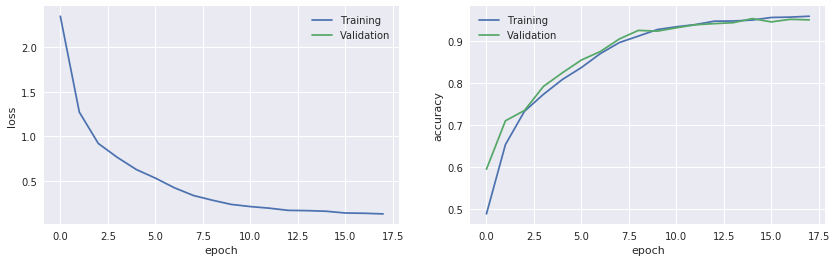


Training loss:  	0.1332
Validation loss: 	nan

Training accuracy: 	0.958
Validation accuracy:	0.950


In [10]:
print('Training...')
callbacks = [keras.callbacks.EarlyStopping(monitor='val_acc', patience=2, verbose=1)]
%time history = model.fit(x_train, y_train, batch_size=1024, epochs=50, verbose=0, \
                          validation_split=0.2, callbacks=callbacks)
helper.show_training(history)

### Make predictions

In [11]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Accuracy: {:.2f}\n".format(score[1]))

y = model.predict(x_test)

for idx, value in enumerate(y):
    print('Sample: {}'.format(test_english_sentences[idx]))
    print('Actual: {}'.format(test_french_sentences[idx]))
    print('Predicted: {}\n'.format(logits_to_text(value, y_tk, show_pad=False)))

Accuracy: 0.96

Sample: california is never nice during october , and it is sometimes rainy in autumn .
Actual: californie est jamais agréable en octobre , et il est parfois pluvieux à l' automne .
Predicted: california est jamais agréable en octobre et il est parfois pluvieux à l' automne       

Sample: our least liked fruit is the apple , but my least liked is the grape .
Actual: notre moins aimé fruit est la pomme , mais mon moins aimé est le raisin .
Predicted: notre moins aimé fruit est la pomme mais mon moins aimé est le raisin       

Sample: we plan to visit china in march .
Actual: nous prévoyons une visite en chine en mars .
Predicted: nous prévoyons de visite la chine en              

Sample: india is sometimes snowy during september , but it is never warm in winter .
Actual: l' inde est parfois enneigée en septembre , mais il est jamais chaud en hiver .
Predicted: l' inde est parfois enneigée en mois de il est jamais chaud en hiver       

Sample: france is never busy dur